<a href="https://colab.research.google.com/github/Rajesh-mandal/Git-Tutorials/blob/main/retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
%cd /content/drive/MyDrive/TGSIN/infilect/

/content/drive/MyDrive/TGSIN/infilect


In [41]:
from matplotlib import pyplot as plt
import seaborn as sns

import os
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import imgaug.augmenters as iaa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# this is an important module to use to serialize the image names in proper sorted order
from natsort import natsorted

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from tqdm import tqdm

# list the image names in proper sorted order
from natsort import natsorted

In [3]:
# used for image augmentations
!pip install --upgrade imgaug
!pip install imagecorruptions

**check the shelf image**

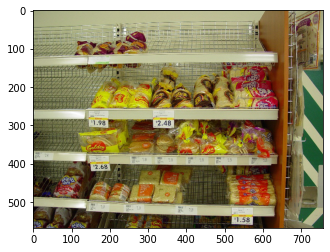

In [42]:

shelf_img_path = '/content/drive/MyDrive/TGSIN/infilect/product_detection_from_packshots/shelf_images/db1.jpg'
plt.imshow(plt.imread(shelf_img_path))

**check the product image**

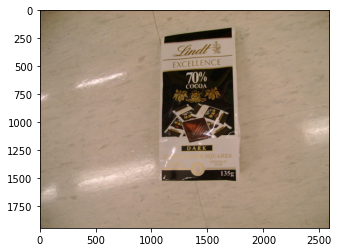

In [44]:
product_img_path = '/content/drive/MyDrive/TGSIN/infilect/product_detection_from_packshots/product_images/qr53.jpg'
plt.imshow(plt.imread(product_img_path))


**Load product images in ascending order**

In [6]:
product_img_path = '/content/drive/MyDrive/TGSIN/infilect/product_detection_from_packshots/product_images/'
# fetch product image list
img_lst = natsorted(os.listdir(product_img_path))
print(img_lst)

['qr1.jpg', 'qr2.jpg', 'qr3.jpg', 'qr4.jpg', 'qr5.jpg', 'qr6.jpg', 'qr7.jpg', 'qr8.jpg', 'qr9.jpg', 'qr10.jpg', 'qr11.jpg', 'qr12.jpg', 'qr13.jpg', 'qr14.jpg', 'qr15.jpg', 'qr16.jpg', 'qr17.jpg', 'qr18.jpg', 'qr19.jpg', 'qr20.jpg', 'qr21.jpg', 'qr22.jpg', 'qr23.jpg', 'qr24.jpg', 'qr25.jpg', 'qr26.jpg', 'qr27.jpg', 'qr28.jpg', 'qr29.jpg', 'qr30.jpg', 'qr31.jpg', 'qr32.jpg', 'qr33.jpg', 'qr34.jpg', 'qr35.jpg', 'qr36.jpg', 'qr37.jpg', 'qr38.jpg', 'qr39.jpg', 'qr40.jpg', 'qr41.jpg', 'qr42.jpg', 'qr43.jpg', 'qr44.jpg', 'qr45.jpg', 'qr46.jpg', 'qr47.jpg', 'qr48.jpg', 'qr49.jpg', 'qr50.jpg', 'qr51.jpg', 'qr52.jpg', 'qr53.jpg', 'qr54.jpg', 'qr55.jpg', 'qr56.jpg', 'qr57.jpg', 'qr58.jpg', 'qr59.jpg', 'qr60.jpg', 'qr61.jpg', 'qr62.jpg', 'qr63.jpg', 'qr64.jpg', 'qr65.jpg', 'qr66.jpg', 'qr67.jpg', 'qr68.jpg', 'qr69.jpg', 'qr70.jpg', 'qr71.jpg', 'qr72.jpg', 'qr73.jpg', 'qr74.jpg', 'qr75.jpg', 'qr76.jpg', 'qr77.jpg', 'qr78.jpg', 'qr79.jpg', 'qr80.jpg', 'qr81.jpg', 'qr82.jpg', 'qr83.jpg', 'qr84.jpg', 

**Generate the dataset containing 102 categories and create  dataframe to load the images** 


In [7]:
class_label = [i for i in range(0,102)]
class_id = 0
df = pd.DataFrame(columns=['Image_Path','Clas_ID'])
for img_id, i in enumerate(img_lst):
    img_path = os.path.join(product_img_path + i)
    id = int(i.split('.')[0].split('qr')[1])
    if id < 289:
        if (id-1) != 0 and (id-1)%3 == 0:
            class_id = class_id+1
            df.loc[img_id,'Image_Path'] = img_path
            df.loc[img_id,'Clas_ID'] = str(class_label[class_id])
        else:
            df.loc[img_id,'Image_Path'] = img_path
            df.loc[img_id,'Clas_ID'] = str(class_label[class_id])
    else:
        if (id-1) != 0 and (id-1)%2 ==0:
            class_id = class_id+1
            df.loc[img_id,'Image_Path'] = img_path
            df.loc[img_id,'Clas_ID'] = str(class_label[class_id])  
        else:
            df.loc[img_id,'Image_Path'] = img_path
            df.loc[img_id,'Clas_ID'] = str(class_label[class_id])     

print(df.iloc[1])
df.to_csv('file1.csv')

Image_Path    /content/drive/MyDrive/TGSIN/infilect/product_...
Clas_ID                                                       0
Name: 1, dtype: object


**Load the DataFrame**

In [8]:
df

,Image_Path,Clas_ID
0,/content/drive/MyDrive/TGSIN/infilect/product_...,0
1,/content/drive/MyDrive/TGSIN/infilect/product_...,0
2,/content/drive/MyDrive/TGSIN/infilect/product_...,0
3,/content/drive/MyDrive/TGSIN/infilect/product_...,1
4,/content/drive/MyDrive/TGSIN/infilect/product_...,1
...,...,...
295,/content/drive/MyDrive/TGSIN/infilect/product_...,99
296,/content/drive/MyDrive/TGSIN/infilect/product_...,100
297,/content/drive/MyDrive/TGSIN/infilect/product_...,100
298,/content/drive/MyDrive/TGSIN/infilect/product_...,101


**Prepare the Datasets**
load the images to list by center cropping (1200,1400)

In [9]:
img_list = []
labels_list = []
#cropped_dimension
(w,h) = (1200,1400)
for img_id_, path in enumerate(df['Image_Path']):
  img_ = plt.imread(path)
  center = [el/2 for el in img_.shape[:2]]
  #print(center)
  x = center[1] - w/2
  y = center[0] - h/2
  img_ = img_[int(y):int(y+h), int(x):int(x+w)]
  img_ = tf.keras.preprocessing.image.smart_resize(img_, size = (256,256), interpolation='bicubic')
  # this maintains(normalizes) the pixel values between 0 and 1
  img_-=img_.min()
  img_/=(img_.max()-img_.min())
  # img_ = img_/255.0
  # append images in a list
  img_list.append(img_)
  labels_list.append(df['Clas_ID'][img_id_])

In [10]:
img_list

[array([[[0.7409582 , 0.7254447 , 0.67890394],
         [0.77433586, 0.75882226, 0.7122816 ],
         [0.7554909 , 0.7399773 , 0.6934366 ],
         ...,
         [0.4410349 , 0.41765445, 0.3611492 ],
         [0.47044066, 0.44000942, 0.39764103],
         [0.49311605, 0.45799482, 0.42352068]],
 
        [[0.72593695, 0.7146259 , 0.6549695 ],
         [0.77002764, 0.7557143 , 0.70456195],
         [0.7745493 , 0.75940084, 0.724001  ],
         ...,
         [0.46367237, 0.42311665, 0.36167216],
         [0.4554158 , 0.43748808, 0.35832435],
         [0.48776916, 0.4706587 , 0.38129663]],
 
        [[0.74595433, 0.72722435, 0.7100226 ],
         [0.74723834, 0.7282956 , 0.71286196],
         [0.7720544 , 0.75647587, 0.71086454],
         ...,
         [0.41010565, 0.37586063, 0.33923662],
         [0.4551378 , 0.40788403, 0.39096594],
         [0.455005  , 0.42151138, 0.35028026]],
 
        ...,
 
        [[0.67936105, 0.65412575, 0.5949369 ],
         [0.67995757, 0.6549802 , 0.59570

In [11]:
labels_list

['0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '3',
 '3',
 '3',
 '4',
 '4',
 '4',
 '5',
 '5',
 '5',
 '6',
 '6',
 '6',
 '7',
 '7',
 '7',
 '8',
 '8',
 '8',
 '9',
 '9',
 '9',
 '10',
 '10',
 '10',
 '11',
 '11',
 '11',
 '12',
 '12',
 '12',
 '13',
 '13',
 '13',
 '14',
 '14',
 '14',
 '15',
 '15',
 '15',
 '16',
 '16',
 '16',
 '17',
 '17',
 '17',
 '18',
 '18',
 '18',
 '19',
 '19',
 '19',
 '20',
 '20',
 '20',
 '21',
 '21',
 '21',
 '22',
 '22',
 '22',
 '23',
 '23',
 '23',
 '24',
 '24',
 '24',
 '25',
 '25',
 '25',
 '26',
 '26',
 '26',
 '27',
 '27',
 '27',
 '28',
 '28',
 '28',
 '29',
 '29',
 '29',
 '30',
 '30',
 '30',
 '31',
 '31',
 '31',
 '32',
 '32',
 '32',
 '33',
 '33',
 '33',
 '34',
 '34',
 '34',
 '35',
 '35',
 '35',
 '36',
 '36',
 '36',
 '37',
 '37',
 '37',
 '38',
 '38',
 '38',
 '39',
 '39',
 '39',
 '40',
 '40',
 '40',
 '41',
 '41',
 '41',
 '42',
 '42',
 '42',
 '43',
 '43',
 '43',
 '44',
 '44',
 '44',
 '45',
 '45',
 '45',
 '46',
 '46',
 '46',
 '47',
 '47',
 '47',
 '48',
 '48',
 '48',
 

**Visualize images**

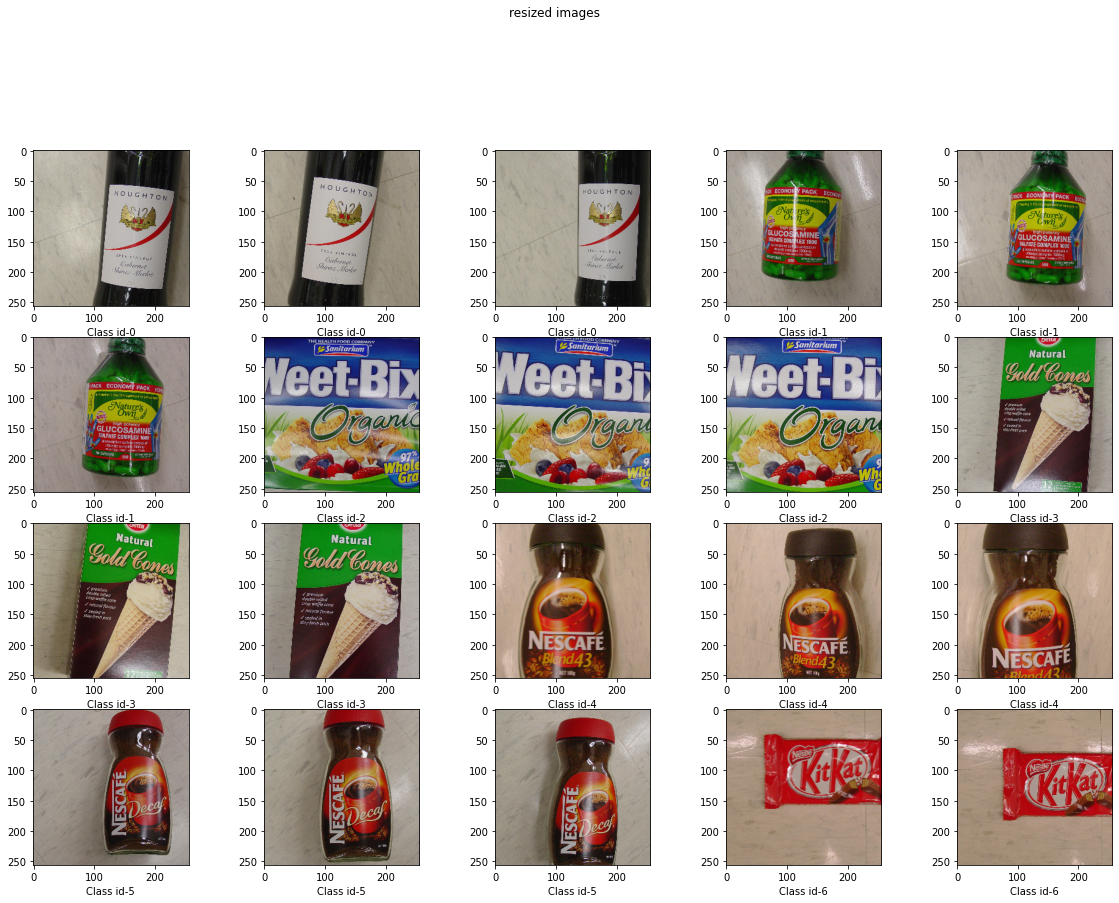

In [12]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('resized images')
for i in range(20):
  fig.add_subplot(6,5,i+1)
  plt.imshow(img_list[i])
  plt.xlabel(f'Class id-{labels_list[i]}')

**Convert train image and labels to numpy array**

In [13]:
img_array = np.array(img_list, dtype = np.float32)
label_array = np.array(labels_list, dtype = np.int32)

print(f'Dataset shape {img_array.shape, label_array.shape}')
print(f'Dataset dtype {img_array.dtype, label_array.dtype}')

Dataset shape ((300, 256, 256, 3), (300,))
Dataset dtype (dtype('float32'), dtype('int32'))


**since we have very less datasets so i am applying augmentation to increase the no. of datasets**

In [14]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    new_img
    return new_img

# image aug function for the dataset having the specified class index
def img_aug(dataset,label, class_idx = 0):
  # fetch the index of the given class idx
  idx_list = [i for i,j in enumerate(label) if j==class_idx]

  # define augmentor objects for auto_contrast, flip with prob=1
  auto_contrast = iaa.pillike.Autocontrast()
  # auto-brightness
  auto_brightness = iaa.imgcorruptlike.Brightness()
  # auto-sharpness
  sharpness = iaa.pillike.EnhanceSharpness()
  # auto-rotate
  rotate = iaa.Rotate(rotate = (-10,10), order=1)
  eq = iaa.pillike.Equalize()
  ec = iaa.pillike.EnhanceColor()

  img_list = list(dataset)

  # augmented images list initialized with dataset
  aug_list = img_list
  # augmented label list initiallized with dataset
  aug_label_list = list(label)
  
  for idx in idx_list:
    img = img_list[idx]
    
    # auto contrast
    img_con = convert(img,0,255,np.uint8)
    img_con = auto_contrast.augment_image(img_con)
    img_con = convert(img_con,0,1,np.float32)
    aug_list.append(img_con)
    aug_label_list.append(class_idx)
    
    # auto-brightness
    img_b = convert(img,0,255,np.uint8)
    img_b = auto_brightness.augment_image(img_b)
    img_b = convert(img_b,0,1,np.float32)
    aug_list.append(img_b)
    aug_label_list.append(class_idx)

    # auto-sharpness
    img_s = convert(img,0,255,np.uint8)
    img_s = sharpness.augment_image(img_s)
    img_s = convert(img_s,0,1,np.float32)
    aug_list.append(img_s)
    aug_label_list.append(class_idx)

    # auto-equalize
    img_eq = convert(img,0,255,np.uint8)
    img_eq = eq.augment_image(img_eq)
    img_eq = convert(img_eq,0,1,np.float32)
    aug_list.append(img_eq)
    aug_label_list.append(class_idx)

    # auto-enhance color
    img_ec = convert(img,0,255,np.uint8)
    img_ec = ec.augment_image(img_ec)
    img_ec = convert(img_ec,0,1,np.float32)
    aug_list.append(img_ec)
    aug_label_list.append(class_idx)

    # auto-rotate
    img_r = convert(img,0,255,np.uint8)
    img_r = rotate.augment_image(img_r)
    img_r = convert(img_r,0,1,np.float32)
    aug_list.append(img_r)
    aug_label_list.append(class_idx)

    # auto contrast
    img_con = convert(img_r,0,255,np.uint8)
    img_con = auto_contrast.augment_image(img_con)
    img_con = convert(img_con,0,1,np.float32)
    aug_list.append(img_con)
    aug_label_list.append(class_idx)
    
    # auto-brightness
    img_b = convert(img_r,0,255,np.uint8)
    img_b = auto_brightness.augment_image(img_b)
    img_b = convert(img_b,0,1,np.float32)
    aug_list.append(img_b)
    aug_label_list.append(class_idx)

    # auto-sharpness
    img_s = convert(img_r,0,255,np.uint8)
    img_s = sharpness.augment_image(img_s)
    img_s = convert(img_s,0,1,np.float32)
    aug_list.append(img_s)
    aug_label_list.append(class_idx)

    # auto-equalize
    img_eq = convert(img_r,0,255,np.uint8)
    img_eq = eq.augment_image(img_eq)
    img_eq = convert(img_eq,0,1,np.float32)
    aug_list.append(img_eq)
    aug_label_list.append(class_idx)

    # auto-enhance color
    img_ec = convert(img_r,0,255,np.uint8)
    img_ec = ec.augment_image(img_ec)
    img_ec = convert(img_ec,0,1,np.float32)
    aug_list.append(img_ec)
    aug_label_list.append(class_idx)

  aug_img_array = np.array(aug_list, dtype=np.float32)
  # normalize the values between 0 and 1
  aug_img_array = aug_img_array - aug_img_array.min()
  aug_label_list_array = np.array(aug_label_list, dtype=np.int32) 
  
  assert aug_img_array.shape[0] == aug_label_list_array.shape[0]
  
  return aug_img_array, aug_label_list_array

In [15]:
# obtain augmented image and labels pair for all the classes
for cls in class_label:
  if cls==0:
    aug_img, aug_label = img_aug(img_array, label_array, class_idx=cls)
  else:
    aug_img, aug_label = img_aug(aug_img, aug_label, class_idx=cls)

In [16]:
aug_img

array([[[[0.7409582 , 0.7254447 , 0.67890394],
         [0.77433586, 0.75882226, 0.7122816 ],
         [0.7554909 , 0.7399773 , 0.6934366 ],
         ...,
         [0.4410349 , 0.41765445, 0.3611492 ],
         [0.47044066, 0.44000942, 0.39764103],
         [0.49311605, 0.45799482, 0.42352068]],

        [[0.72593695, 0.7146259 , 0.6549695 ],
         [0.77002764, 0.7557143 , 0.70456195],
         [0.7745493 , 0.75940084, 0.724001  ],
         ...,
         [0.46367237, 0.42311665, 0.36167216],
         [0.4554158 , 0.43748808, 0.35832435],
         [0.48776916, 0.4706587 , 0.38129663]],

        [[0.74595433, 0.72722435, 0.7100226 ],
         [0.74723834, 0.7282956 , 0.71286196],
         [0.7720544 , 0.75647587, 0.71086454],
         ...,
         [0.41010565, 0.37586063, 0.33923662],
         [0.4551378 , 0.40788403, 0.39096594],
         [0.455005  , 0.42151138, 0.35028026]],

        ...,

        [[0.67936105, 0.65412575, 0.5949369 ],
         [0.67995757, 0.6549802 , 0.59570855]

In [17]:
aug_label

array([  0,   0,   0, ..., 101, 101, 101], dtype=int32)

In [18]:
print(f'Augmented Dataset shape {aug_img.shape, aug_label.shape}')
print(f'Augmented dtype {aug_img.dtype, aug_label.dtype}')

Augmented Dataset shape ((3600, 256, 256, 3), (3600,))
Augmented dtype (dtype('float32'), dtype('int32'))


In [19]:
print(f'Total images correponding to individual categories after augmentation {list(aug_label).count(0)}')

Total images correponding to individual categories after augmentation 36


**Visualize augmented samples**

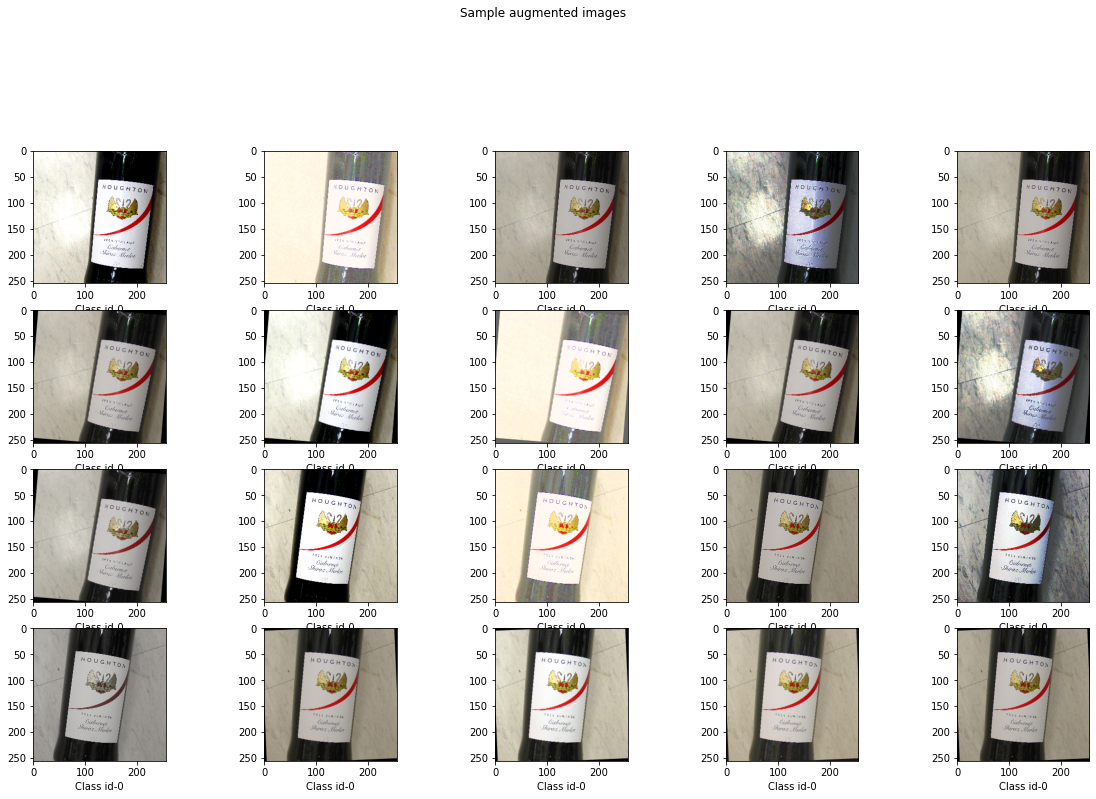

In [20]:
# plot 20 sample images
fig = plt.figure(figsize=(20,20))
fig.suptitle('Sample augmented images')
for i in range(20):
  fig.add_subplot(7,5,i+1)
  plt.imshow(aug_img[300+i])
  plt.xlabel(f'Class id-{aug_label[300+i]}')

**Train and Test validation set**

In [21]:
train_img, valid_main_img, train_label, valid_main_label = train_test_split(aug_img,
                                                                  aug_label,
                                                                  stratify = aug_label,
                                                                  test_size = 0.2,
                                                                  shuffle = True,
                                                                  random_state = 42) 

valid_img, test_img, valid_label, test_label = train_test_split(valid_main_img,
                                                                  valid_main_label,
                                                                  stratify = valid_main_label,
                                                                  test_size = 0.5,
                                                                  shuffle = True,
                                                                  random_state = 42)

In [22]:
print(f'Train set dimension and datatype {train_img.shape, train_img.dtype, train_label.shape, train_label.dtype}')
print(f'Validation set dimension {valid_img.shape, valid_img.dtype, valid_label.shape, valid_label.dtype}')
print(f'Test set dimension and datatype {test_img.shape, test_img.dtype, test_label.shape, test_label.dtype}')

Train set dimension and datatype ((2880, 256, 256, 3), dtype('float32'), (2880,), dtype('int32'))
Validation set dimension ((360, 256, 256, 3), dtype('float32'), (360,), dtype('int32'))
Test set dimension and datatype ((360, 256, 256, 3), dtype('float32'), (360,), dtype('int32'))


In [23]:
def create_resnet50v2_model():
  conv_base = tf.keras.applications.ResNet50V2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(256, 256, 3),
    pooling='avg'
  )
  
  model = Sequential()
  model.add(conv_base)
  model.add(Dense(102, activation='softmax'))

  return model

In [24]:
model = create_resnet50v2_model()

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,773,798
Trainable params: 23,728,358
Non-trainable params: 45,440
_________________________________________________________________


In [26]:
# here we are freezing the base model
def freeze_model(model):
  for layer in model.layers:
    layer.trainable = False

In [27]:
conv_base = model.get_layer('resnet50v2')
#classifier = model.get_layer('dense_1')

# Freeze convolutional base
freeze_model(conv_base)
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,773,798
Trainable params: 208,998
Non-trainable params: 23,564,800
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
# mc_filepath ='/content/drive/MyDrive/TGSIN/infilect/product_best_model1.h5'
# mcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=mc_filepath, monitor='val_loss',verbose = 1, save_best_only=True, save_freq=375, mode ='min')


In [30]:
# history = model.fit(x = train_img, y = train_label, batch_size= 16, epochs = 10, verbose=1, validation_data=(valid_img, valid_label), callbacks=[mcheckpoint])

In [31]:
# save trained model
# model.save('/content/drive/MyDrive/TGSIN/infilect/product_best_model1.h5')

In [32]:
# weight path
weight_file = '/content/drive/MyDrive/TGSIN/infilect/product_best_model1.h5'
model.load_weights(weight_file)

In [37]:
model.evaluate(test_img, test_label)

12/12 [==============================] - 2s 120ms/step - loss: 0.0059 - acc: 1.0000


[0.005933959502726793, 1.0]

In [34]:
test_pred = model.predict(test_img)
test_pred = np.argmax(test_pred, 1)
print(test_pred)

[  0  29  76  70  38  23  74  65  14   7  22  18  52  63 101 101  68   7
  31  99  34  53  20  51  22  44  96  85  30  62  98  58   5  92   1  94
  19  16  72  58   6   1  11   5  68  84  69  12  53  77  28  27  17  40
  14  18  46  88  52  33  15  50  52  52   6  12  56   2  53  55  79  21
   3  32  55  70   5  97  75  46   0  97  69  92   9  65  48  27  72   8
  44  20   1  22  13  56  74  87  23  86  67  68   4  62  73  40  75  26
  92   9  51  90  65  87  91  67  61  70  15  66  16  39  59  83  33  72
  18  38  26  76  38  24  34  72  79  43  36  28  71   2  35  99  45  77
  31  58  90  78   4   4  40   8  49  49   8  89  78  71  91  20  47  70
  57  79  78  73  29 100  22  13  31  43  83  41  54  64  49  45  24  54
  42  82  30  69  35   4  25  45  37  75  98  21  61   6  59  94  47  43
  32  63  50  64  14  56  49  61  86 100  92  15  77  86  62  16  60  51
  45  30  25  41  98  12  94  42  73  60  11  10  57   7  14  95  33   8
  25  29  35  20  10  33  36  19  67  27  95  57  4

Classification report               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
     

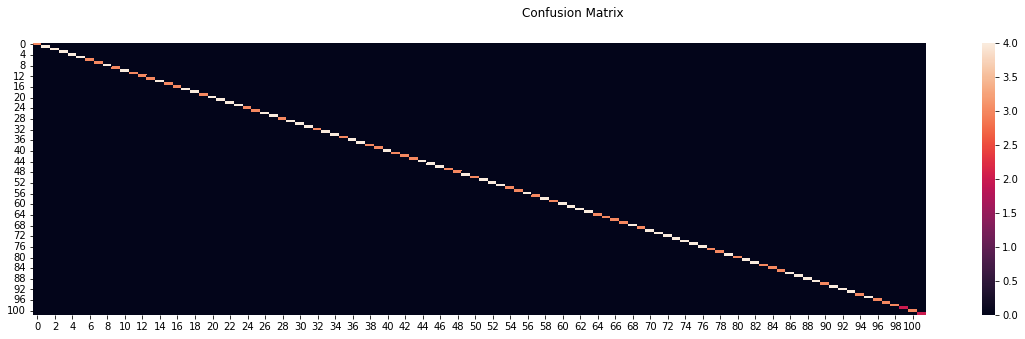

In [36]:
print(f'Classification report {metrics.classification_report(test_label, test_pred)}')

fig_cm = plt.figure(figsize=(20,5))
fig_cm.suptitle('Confusion Matrix')
sns.heatmap(confusion_matrix(test_label, test_pred))